I preload all the necessary packages needed for ML, data loading, processing and visualization.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
#import imagehash

%matplotlib inline 
#To plot within the notebook
from sklearn.decomposition import PCA # Surmoning the Principal Component Gods
import skimage.transform as imtran # The wizard of Image transformation. They do a mean Image resize
from PIL import Image # This one is a bit boring, Opens images, bla bla bla, the usual.
from mpl_toolkits.mplot3d import Axes3D # 3D projections that are actually better than imax!
import glob #An earth wannabe, 'global environment' package.
# Input data files are available in the "../input/" directory.
from sklearn.preprocessing import StandardScaler
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from pylab import array, plot, show, axis, arange, figure, uint8
import os
print(os.listdir("./APTOS_DATA/"))

# Any results you write to the current directory are saved as output.

['test_images', 'test.csv', 'train.csv', 'train_images', 'sample_submission.csv']


Load the training labels. Given that our dataset is limited, we will make use of the training label to both train and test this quick and dirty approach.

In [2]:
train_labels = pd.read_csv("./APTOS_DATA/train.csv")
print(len(train_labels))
train_labels.head()

3662


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


I use this to increase the intensity of the the black patches in the images. i noticed this helps with the accuracy as the level of severity of a person with blindness can be told from the level of intensity of the black patches and given that the contrast transformation is similar for all images, it really does not not distort the results. Make sure to do the same for the test set though. This might slow down your algorithm though.

In [3]:
def increase_contrast(image):
    #Sourced:
    #https://stackoverflow.com/questions/19363293/...
    #...whats-the-fastest-way-to-increase-color-image-contrast-with-opencv-in-python-c
    maxIntensity = 255.0 # depends on dtype of image data
    x = arange(maxIntensity) 

    # Parameters for manipulating image data
    phi = 1
    theta = 1

    # Increase intensity such that
    # dark pixels become much brighter, 
    # bright pixels become slightly bright
    newImage0 = (maxIntensity/phi)*(image/(maxIntensity/theta))**0.5
    newImage0 = array(newImage0,dtype=uint8)

   

    y = (maxIntensity/phi)*(x/(maxIntensity/theta))**0.5

    # Decrease intensity such that
    # dark pixels become much darker, 
    # bright pixels become slightly dark 
    newImage1 = (maxIntensity/phi)*(image/(maxIntensity/theta))**2
    newImage1 = array(newImage1,dtype=uint8)
    return newImage1

I use this function to load the images and standardize them. This is the first standardization step and I think it is well done durng preloading. I also do an incersion of the image which, while it distort the colors, it really helps emphasize the black patches within the eye ball scans. This I noticed helped improve the accuracy of detection.

In [4]:
size = (256, 256)
def load_images_from_folder(folder, labels, tr):
    images, names, im_diagnostics = [],[],[]
    kernel = np.ones((3,3),np.float32)/9
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        
        if img is not None:
            #Increase Contrast
            img = increase_contrast(img)
            filename = filename.split(".")[0]
            names.append(filename)
            if tr:
                im_diagnostics.append(int(labels[labels["id_code"] == filename].diagnosis))
            image_resized = cv2.resize(img, size)
            image_filtered = cv2.filter2D(image_resized,-1,kernel)
            #invert
            image_inverted = cv2.bitwise_not(image_resized)
            gray_image = cv2.cvtColor(image_inverted,cv2.COLOR_BGR2RGB)
            images.append(gray_image)
    return images, names, im_diagnostics



Load the training images. Note, for this, you only need the training images given that we dont have the training labels. The competition does not give us these so our training dataset will have to suffice for cross validation and testing purposes. I never has a CV set though since I wanted to do a quick and dirty implementation so how the way the algorithm scales might be questionable. Nonetheless, I think I can mitigate this by fitting multiple algorithms then allowing them to vote and take the modal vote. In case of a tie, just trust the most accurate of the algorithms so far.

In [5]:
images, im_names, im_diagnostics = load_images_from_folder('./APTOS_DATA/train_images', labels = train_labels, tr= True)

In [6]:
images_ts_main, im_names_ts_main, im_diagnostics_ts = load_images_from_folder('./APTOS_DATA/test_images', labels = train_labels,tr=False)

In [7]:
print(f"Images Loaded: {len(images)} Labels Organized: {len(im_diagnostics)}")

Images Loaded: 3662 Labels Organized: 3662


A simple utility to display the images.

These are sample Images: df4aec4a0eaf-->4, 6852f4531591-->0, 9122b31414d3-->0 Respectively


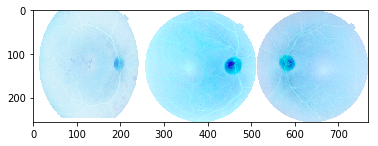

These are sample Images: c1896142a20a-->4, df84e7113003-->4, 2a3378bcfbcc-->2 Respectively


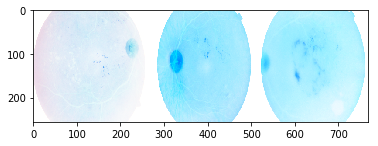

These are sample Images: b5834ee64541-->3, bf9cba745efc-->2, d66b6f333dc7-->1 Respectively


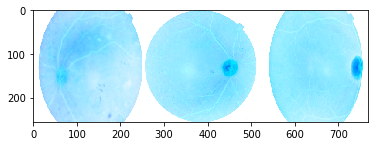

In [8]:
def display_image(images, labels, im_names, rows = 1,columns = 3):
    count = 0
    #You can visualize a random sample
    sampleList = np.random.choice(range(len(images)), 12, replace = False)
    
    simages, sim_names = [], [] 
    for i in sampleList:
        simages.append(images[i])
        sim_names.append(im_names[i]+"-->"+str(labels[i]))
    
    for i in range(1, len(sampleList)//3):
        plot_image = np.concatenate((simages[count],simages[count+1],simages[count+2]), axis=1)
        
        plt.imshow(plot_image)
        print(f"These are sample Images: {', '.join(sim_names[count:count+3])} Respectively")
        plt.show() 
        count+=3
        
display_image(images,im_diagnostics, im_names=im_names, rows=4)

In [9]:
#Used this to verify the labels were correctly retrieved
print(int(train_labels[train_labels["id_code"] == "b3d12069e1c5"].diagnosis))

2


I perform PCA on this retaining 99% of the variance also partition the testing set. Ts main is the main label. The best fitting model is one trained over the whole data set so for submission purposes, I simply removed the partitioning on the training model and used this to make predictions on ts_images_main. I also performed standard scaling on this so that the mean is 0. This is especially beneficial for the neural network performance. 

In [10]:
#Run a basic neural network on the data
from sklearn.neural_network import MLPClassifier
import random
#I reduce the number of features with PCA
from sklearn.decomposition import PCA
scaler= StandardScaler()

pca = PCA(.99)

#Stratification into training and testing data.
#I will add the CV data later
tr_images  = pca.fit_transform(scaler.fit_transform([img.flatten() for img in images[:3001]]))
tr_labels = im_diagnostics[:3001]
ts_images  = pca.transform(scaler.transform([img.flatten()for img in images[3001:]]))
ts_labels = im_diagnostics[3001:]
ts_images_main=pca.transform(scaler.transform([img.flatten()for img in images_ts_main]))

Algorithm one, Use a simple Multi-Layer Perceptron with 5 hidden layer of size (input)//2. This is borne out of testing. You may play around with the model but this configration wourked well for me so I stuck for it.

In [35]:
#Now Lets Fit a neural Network on a portion of the data just to keep things fast and for testing
print("Fitting Model")
layers = [(((pca.n_components_))//2)]*5
clf = MLPClassifier(activation = "relu",solver = "sgd", hidden_layer_sizes=tuple(layers))
clf.fit(tr_images, tr_labels)
from sklearn.metrics import accuracy_score

prediction_nn = clf.predict(ts_images)
main_prediction_nn = clf.predict(ts_images_main)
print(set(prediction_nn))
print(f"First 10 labels: {ts_labels[:10]}")
print(f"First 10 prediction: {prediction_nn[:10]}")
acc_nn=accuracy_score(prediction_nn, ts_labels)
print(acc_nn)

Fitting Model
{0, 1, 2, 3, 4}
First 10 labels: [0, 2, 2, 0, 0, 0, 0, 2, 1, 0]
First 10 prediction: [0 2 0 0 2 2 2 2 1 0]
0.7503782148260212


Test 2: Logistic regression with a Stochastic Average Gradient descent solver which works well for large datasets. Our data may seem given how few images we have but note, we are flattening the images and even though PCA helps reduce the number of features, we still have almost 1000 principal compnents to explain 99% of the variance. At 95%, they are about 400. Feel free to play around with this but I wanted to go overkill hence. This is a ton of data. For 3000 images, that is 3000000 datapoints. Thats why SAGA performed well.

In [38]:
#Lets also attempt Multiclass Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(multi_class="auto",solver= "saga")

logistic.fit(tr_images, tr_labels)
prediction_lg = logistic.predict(ts_images)
main_prediction_lg = logistic.predict(ts_images_main)
print(set(prediction_lg)) 
print(f"First 10 labels: {ts_labels[:10]}")
print(f"First 10 prediction: {prediction_lg[:10]}")
acc_lg = accuracy_score(prediction_lg, ts_labels)
print(acc_lg)

{0, 1, 2, 3, 4}
First 10 labels: [0, 2, 2, 0, 0, 0, 0, 2, 1, 0]
First 10 prediction: [0 0 1 0 0 2 3 4 1 0]
0.745839636913767


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


I perform the same classification using an SVC. I used a polynormial kernel of degree 4. This was a number I arrived to by testing. This gave me the highest accuracy though it increases the likelihood of overfitting. I trust though that the modal apprach I will use will mitigate such cases.

In [40]:
#Lets also attempt Multiclass Logistic Regression
from sklearn.svm import SVC
svc = SVC(kernel = "poly", degree= 3, gamma = "scale")

svc.fit(tr_images, tr_labels)
prediction_svc = svc.predict(ts_images)
main_prediction_svc = svc.predict(ts_images_main)
print(set(prediction_svc)) 
print(f"First 10 labels: {ts_labels[:10]}")
print(f"First 10 prediction: {prediction_svc[:10]}")
acc_svc = accuracy_score(prediction_svc, ts_labels)
print(acc_svc)

{0, 1, 2, 3}
First 10 labels: [0, 2, 2, 0, 0, 0, 0, 2, 1, 0]
First 10 prediction: [0 2 2 0 0 2 2 2 2 0]
0.7186081694402421


I am making use of the combined opinions of the different models to make a selection. Take the mode of the votes or if the is a tie, take the vote of the most accurate of the models.

In [41]:
from statistics import mode
combo = []
max_accs = [acc_svc, acc_lg,acc_nn].index(max([acc_svc, acc_lg,acc_nn]))
for votes in zip(prediction_svc,prediction_lg,prediction_nn):
    try:
        combo.append(mode(votes))
    except:
        combo.append(votes[max_accs])
print(f"First 10 labels: {ts_labels[:10]}")
print(f"First 10 prediction: {combo[:10]}")
print(accuracy_score(combo, ts_labels))

First 10 labels: [0, 2, 2, 0, 0, 0, 0, 2, 1, 0]
First 10 prediction: [0, 2, 0, 0, 0, 2, 2, 2, 1, 0]
0.7639939485627837


This was used for submission purposes. 

In [15]:
from statistics import mode
main_combo = []


for votes in zip(main_prediction_svc,main_prediction_lg,main_prediction_nn):
    try:
        main_combo.append(mode(votes))
    except:
        main_combo.append(votes[max_accs])


submission = pd.DataFrame({"id_code":im_names_ts_main, "diagnosis":main_combo})
submission.head()
submission.to_csv('sample_submission.csv')